In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on the max sensitivity within a minimum required specificity.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []
    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    # Calculate max sensitivity where specificity is >= 1 - prevalence
    prevalence = sum(true_labels) / len(true_labels)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = 1 - fpr[i]
        if specificity >= 1 - prevalence:
            max_sensitivity = max(max_sensitivity, tpr[i])
    print(f"Max Sensitivity at Specificity >= {1 - prevalence:.2f}: {max_sensitivity:.2f}")
    
    # Confusion Matrix
    threshold_for_max_sensitivity = thresholds[np.argmax(tpr == max_sensitivity)]
    final_predicted_labels = [1 if p > threshold_for_max_sensitivity else 0 for p in predicted_probs]
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    
    # Plot the confusion matrix
    f, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Purples", linecolor="gray", fmt='.1f', ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)
    
    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        f'Max Sensitivity at Specificity {1 - prevalence:.2f}': [max_sensitivity],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 
    
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)
    
    # Plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# Define a function to build a model transforming first layer to take grayscale

In [7]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

# Image Augmentation

In [8]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

# ResNet18-TL-no-CW

In [18]:
!pip install image-classifiers

In [19]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## Train on anterior placental images only

In [20]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-v2/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-v2/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-v2/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 384 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [21]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

train_data_augmented = prep_train_data.map(augment_image)

In [22]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


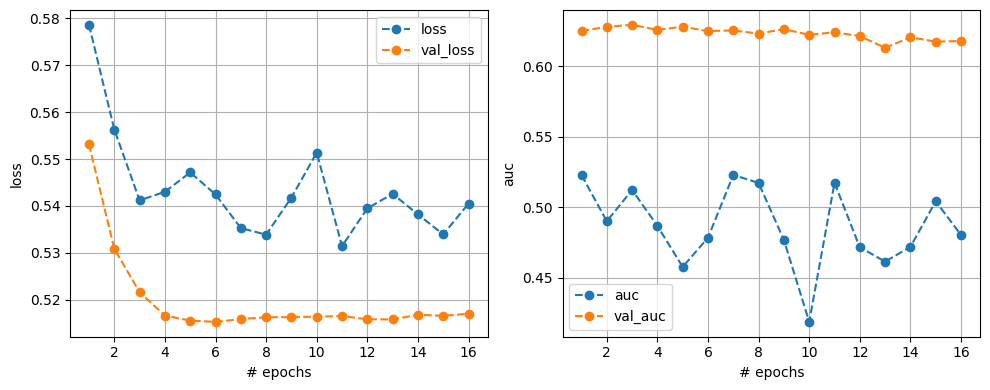

12/12 [==============================] - 3s 184ms/step - loss: 0.5405 - auc: 0.4802 - val_loss: 0.5170 - val_auc: 0.6177
Training time: 53.406660079956055 seconds


In [23]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

start = time.time()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Max Sensitivity at Specificity >= 0.79: 0.11


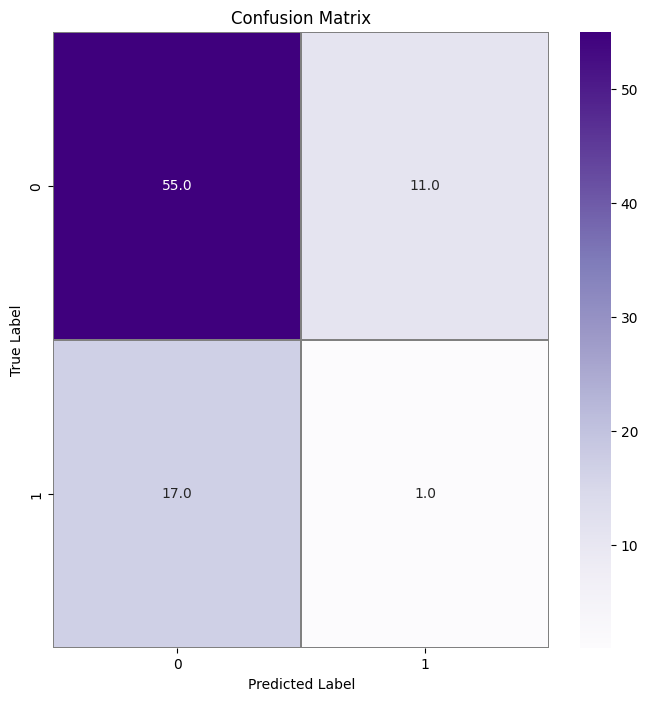

              precision    recall  f1-score   support

           0       0.76      0.83      0.80        66
           1       0.08      0.06      0.07        18

    accuracy                           0.67        84
   macro avg       0.42      0.44      0.43        84
weighted avg       0.62      0.67      0.64        84

                   Model Name  Max Sensitivity at Specificity 0.79   AUC  \
0  ResNet18-TL-no-CW-anterior                                 0.11  0.35   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.07      0.67         0.06         0.83  0.08  0.76   

    PLR   NLR  
0  0.33  1.13  


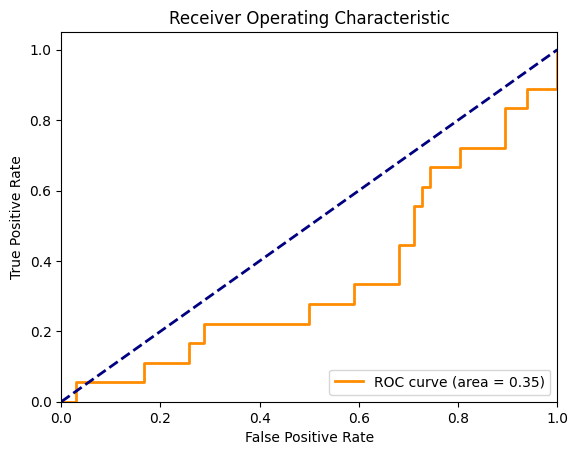

In [24]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL-no-CW-anterior')

# Hyperparameter tuning of best model (both planes)

Best model after re-training on different planes: original or anterior plane.

In [25]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask-v2/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask-v2/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask-v2/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 611 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 363 files belonging to 2 classes.


In [26]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

train_data_augmented = prep_train_data.map(augment_image)

In [31]:
# Custom metric function for optimization
def sensitivity_at_specificity(val_test, model, min_specificity):    
    predicted_probs = []
    true_labels = []
    for images, labels in val_test:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])
        
    # ROC AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)
    
    max_sensitivity = 0
    for i in range(len(fpr)):
        specificity = min_specificity
        if specificity >= min_specificity:
            max_sensitivity = max(max_sensitivity, tpr[i])
    
    return max_sensitivity

In [36]:
import optuna

def build_model(base_model, transfer_learning, trial):
    if transfer_learning == 'Y':
        base_model.trainable = False
    else:
        base_model.trainable = True

    input_layer = Input(shape=(224, 224, 1), name='greyscale_input')
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        x = Dense(trial.suggest_int('units_l{}'.format(i), 50, 200), activation='relu')(x)
        dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=outputs)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=METRICS)

    return model


def objective(trial):
    base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y', trial=trial)

    rn_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    rn_checkpoint = tf.keras.callbacks.ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)

    start = time.time()
    history = model_resnet18.fit(train_data_augmented,
                              epochs=150,
                              validation_data=prep_val_data,
                              callbacks=[rn_callback, rn_checkpoint]
                             )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    #_, auc = model_resnet18.evaluate(prep_val_data, verbose=0)
    #return auc

    sensitivity = sensitivity_at_specificity(prep_val_data, model_resnet18, 0.8)

    
    return sensitivity

In [37]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-23 12:26:28,941] A new study created in memory with name: no-name-81b7c624-9bd6-46d7-af5a-0b25ce98407a


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 8s 157ms/step - loss: 0.8412 - auc: 0.5166 - val_loss: 0.7346 - val_auc: 0.5610
Epoch 2/150
20/20 [==============================] - 4s 133ms/step - loss: 0.8769 - auc: 0.4326 - val_loss: 0.7282 - val_auc: 0.5683
Epoch 3/150
20/20 [==============================] - 3s 131ms/step - loss: 0.8298 - auc: 0.4854 - val_loss: 0.7220 - val_auc: 0.5687
Epoch 4/150
20/20 [==============================] - 4s 134ms/step - loss: 0.8156 - auc: 0.4985 - val_loss: 0.7163 - val_auc: 0.5679
Epoch 5/150
20/20 [==============================] - 3s 131ms/step - loss: 0.8123 - auc: 0.4843 - val_loss: 0.7105 - val_auc: 0.5779
Epoch 6/150
20/20 [==============================] - 4s 141ms/step - loss: 0.7815 - auc: 0.5283 - val_loss: 0.7050 - val_auc: 0.5745
Epoch 7/150
20/20 [==============================] - 3s 131ms/step - loss: 0.7927 - auc: 0.4732 - val_loss: 0.6998 - val_auc: 0.5845
Epoch 8/150
20/20 [==============================] - 3s 132ms/step - loss: 0.7828

[I 2023-12-23 12:35:27,180] Trial 0 finished with value: 1.0 and parameters: {'n_layers': 3, 'units_l0': 97, 'dropout_l0': 0.4697269061354806, 'units_l1': 178, 'dropout_l1': 0.28764854545683954, 'units_l2': 167, 'dropout_l2': 0.4328441697338675, 'learning_rate': 1.4045619171564136e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 154ms/step - loss: 0.9107 - auc: 0.4984 - val_loss: 0.8776 - val_auc: 0.5903
Epoch 2/150
20/20 [==============================] - 4s 141ms/step - loss: 0.8252 - auc: 0.5173 - val_loss: 0.7935 - val_auc: 0.6022
Epoch 3/150
20/20 [==============================] - 3s 130ms/step - loss: 0.7647 - auc: 0.5164 - val_loss: 0.7237 - val_auc: 0.6146
Epoch 4/150
20/20 [==============================] - 3s 132ms/step - loss: 0.7140 - auc: 0.5218 - val_loss: 0.6683 - val_auc: 0.6231
Epoch 5/150
20/20 [==============================] - 4s 136ms/step - loss: 0.6811 - auc: 0.4821 - val_loss: 0.6248 - val_auc: 0.6377
Epoch 6/150
20/20 [==============================] - 4s 132ms/step - loss: 0.6403 - auc: 0.5009 - val_loss: 0.5921 - val_auc: 0.6431
Epoch 7/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6052 - auc: 0.5320 - val_loss: 0.5652 - val_auc: 0.6489
Epoch 8/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6052

[I 2023-12-23 12:37:48,828] Trial 1 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 135, 'dropout_l0': 0.23587811608125156, 'learning_rate': 7.705061599306763e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 169ms/step - loss: 0.7930 - auc: 0.4815 - val_loss: 0.5564 - val_auc: 0.5340
Epoch 2/150
20/20 [==============================] - 4s 134ms/step - loss: 0.6005 - auc: 0.4980 - val_loss: 0.4983 - val_auc: 0.5687
Epoch 3/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5830 - auc: 0.4725 - val_loss: 0.4955 - val_auc: 0.5938
Epoch 4/150
20/20 [==============================] - 3s 131ms/step - loss: 0.5648 - auc: 0.4875 - val_loss: 0.4949 - val_auc: 0.5972
Epoch 5/150
20/20 [==============================] - 4s 132ms/step - loss: 0.5646 - auc: 0.4986 - val_loss: 0.4944 - val_auc: 0.5899
Epoch 6/150
20/20 [==============================] - 4s 133ms/step - loss: 0.5534 - auc: 0.5042 - val_loss: 0.4933 - val_auc: 0.5976
Epoch 7/150
20/20 [==============================] - 3s 131ms/step - loss: 0.5611 - auc: 0.5077 - val_loss: 0.4928 - val_auc: 0.6030
Epoch 8/150
20/20 [==============================] - 4s 132ms/step - loss: 0.5678

[I 2023-12-23 12:40:06,364] Trial 2 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 178, 'dropout_l0': 0.3068661182585272, 'learning_rate': 3.030839789089627e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 8s 157ms/step - loss: 0.6286 - auc: 0.5123 - val_loss: 0.5737 - val_auc: 0.5602
Epoch 2/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6139 - auc: 0.5428 - val_loss: 0.5690 - val_auc: 0.5613
Epoch 3/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6258 - auc: 0.4974 - val_loss: 0.5647 - val_auc: 0.5583
Epoch 4/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6253 - auc: 0.4661 - val_loss: 0.5614 - val_auc: 0.5629
Epoch 5/150
20/20 [==============================] - 4s 135ms/step - loss: 0.6151 - auc: 0.4980 - val_loss: 0.5579 - val_auc: 0.5664
Epoch 6/150
20/20 [==============================] - 4s 135ms/step - loss: 0.5993 - auc: 0.5215 - val_loss: 0.5549 - val_auc: 0.5671
Epoch 7/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5830 - auc: 0.5661 - val_loss: 0.5519 - val_auc: 0.5656
Epoch 8/150
20/20 [==============================] - 4s 134ms/step - loss: 0.5952

[I 2023-12-23 12:46:50,689] Trial 3 finished with value: 1.0 and parameters: {'n_layers': 3, 'units_l0': 194, 'dropout_l0': 0.346889035701632, 'units_l1': 123, 'dropout_l1': 0.2617864882892064, 'units_l2': 138, 'dropout_l2': 0.25043890281134973, 'learning_rate': 1.8604352049599583e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 8s 157ms/step - loss: 0.9508 - auc: 0.5200 - val_loss: 0.8784 - val_auc: 0.5525
Epoch 2/150
20/20 [==============================] - 3s 131ms/step - loss: 0.9705 - auc: 0.4775 - val_loss: 0.8647 - val_auc: 0.5586
Epoch 3/150
20/20 [==============================] - 3s 131ms/step - loss: 0.9836 - auc: 0.4106 - val_loss: 0.8515 - val_auc: 0.5579
Epoch 4/150
20/20 [==============================] - 3s 132ms/step - loss: 0.8996 - auc: 0.5271 - val_loss: 0.8392 - val_auc: 0.5637
Epoch 5/150
20/20 [==============================] - 3s 132ms/step - loss: 0.8979 - auc: 0.5356 - val_loss: 0.8268 - val_auc: 0.5598
Epoch 6/150
20/20 [==============================] - 3s 132ms/step - loss: 0.9004 - auc: 0.5131 - val_loss: 0.8144 - val_auc: 0.5706
Epoch 7/150
20/20 [==============================] - 3s 133ms/step - loss: 0.9179 - auc: 0.4529 - val_loss: 0.8023 - val_auc: 0.5772
Epoch 8/150
20/20 [==============================] - 4s 141ms/step - loss: 0.8861

[I 2023-12-23 12:55:53,070] Trial 4 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 117, 'dropout_l0': 0.34139899541745344, 'learning_rate': 1.093865423738531e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 156ms/step - loss: 0.8033 - auc: 0.4914 - val_loss: 0.6398 - val_auc: 0.4325
Epoch 2/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6398 - auc: 0.5183 - val_loss: 0.5579 - val_auc: 0.4761
Epoch 3/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6001 - auc: 0.5228 - val_loss: 0.5234 - val_auc: 0.4934
Epoch 4/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5820 - auc: 0.5105 - val_loss: 0.5141 - val_auc: 0.5019
Epoch 5/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5805 - auc: 0.5144 - val_loss: 0.5115 - val_auc: 0.5158
Epoch 6/150
20/20 [==============================] - 4s 145ms/step - loss: 0.5853 - auc: 0.5024 - val_loss: 0.5110 - val_auc: 0.5108
Epoch 7/150
20/20 [==============================] - 3s 125ms/step - loss: 0.5797 - auc: 0.4943 - val_loss: 0.5128 - val_auc: 0.5066
Epoch 8/150
20/20 [==============================] - 3s 125ms/step - loss: 0.5522

[I 2023-12-23 12:57:38,958] Trial 5 finished with value: 1.0 and parameters: {'n_layers': 3, 'units_l0': 104, 'dropout_l0': 0.4228666683018333, 'units_l1': 97, 'dropout_l1': 0.3089237160625553, 'units_l2': 150, 'dropout_l2': 0.45192130965370986, 'learning_rate': 6.330305888089174e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 156ms/step - loss: 0.7545 - auc: 0.5172 - val_loss: 0.5421 - val_auc: 0.5158
Epoch 2/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6348 - auc: 0.5356 - val_loss: 0.5402 - val_auc: 0.5150
Epoch 3/150
20/20 [==============================] - 4s 143ms/step - loss: 0.6399 - auc: 0.5209 - val_loss: 0.5347 - val_auc: 0.5069
Epoch 4/150
20/20 [==============================] - 3s 133ms/step - loss: 0.6715 - auc: 0.4563 - val_loss: 0.5345 - val_auc: 0.5004
Epoch 5/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6155 - auc: 0.5253 - val_loss: 0.5307 - val_auc: 0.5031
Epoch 6/150
20/20 [==============================] - 4s 132ms/step - loss: 0.6054 - auc: 0.5191 - val_loss: 0.5275 - val_auc: 0.5035
Epoch 7/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6157 - auc: 0.4842 - val_loss: 0.5264 - val_auc: 0.5019
Epoch 8/150
20/20 [==============================] - 3s 123ms/step - loss: 0.5867

[I 2023-12-23 12:59:58,258] Trial 6 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 135, 'dropout_l0': 0.4968953716558967, 'learning_rate': 7.198674878175584e-05}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 154ms/step - loss: 0.7358 - auc: 0.4947 - val_loss: 0.5950 - val_auc: 0.4660
Epoch 2/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6633 - auc: 0.5154 - val_loss: 0.5739 - val_auc: 0.4722
Epoch 3/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6813 - auc: 0.4806 - val_loss: 0.5558 - val_auc: 0.4749
Epoch 4/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6698 - auc: 0.4892 - val_loss: 0.5413 - val_auc: 0.4857
Epoch 5/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6384 - auc: 0.4754 - val_loss: 0.5329 - val_auc: 0.4977
Epoch 6/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6436 - auc: 0.4739 - val_loss: 0.5257 - val_auc: 0.4946
Epoch 7/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6016 - auc: 0.5282 - val_loss: 0.5208 - val_auc: 0.5096
Epoch 8/150
20/20 [==============================] - 4s 149ms/step - loss: 0.6187

[I 2023-12-23 13:03:18,540] Trial 7 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 116, 'dropout_l0': 0.36083329708894674, 'units_l1': 113, 'dropout_l1': 0.4101219004918212, 'learning_rate': 7.4347400087929935e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 7s 156ms/step - loss: 0.7653 - auc: 0.5444 - val_loss: 0.6145 - val_auc: 0.5463
Epoch 2/150
20/20 [==============================] - 3s 131ms/step - loss: 0.7951 - auc: 0.4892 - val_loss: 0.5978 - val_auc: 0.5521
Epoch 3/150
20/20 [==============================] - 3s 132ms/step - loss: 0.7322 - auc: 0.5203 - val_loss: 0.5832 - val_auc: 0.5583
Epoch 4/150
20/20 [==============================] - 3s 129ms/step - loss: 0.7431 - auc: 0.4926 - val_loss: 0.5705 - val_auc: 0.5679
Epoch 5/150
20/20 [==============================] - 4s 150ms/step - loss: 0.7306 - auc: 0.4779 - val_loss: 0.5610 - val_auc: 0.5756
Epoch 6/150
20/20 [==============================] - 4s 136ms/step - loss: 0.7059 - auc: 0.5204 - val_loss: 0.5510 - val_auc: 0.5818
Epoch 7/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6759 - auc: 0.5267 - val_loss: 0.5420 - val_auc: 0.5837
Epoch 8/150
20/20 [==============================] - 4s 130ms/step - loss: 0.7222

[I 2023-12-23 13:06:15,212] Trial 8 finished with value: 1.0 and parameters: {'n_layers': 1, 'units_l0': 198, 'dropout_l0': 0.4860858236974576, 'learning_rate': 1.7501684560410827e-06}. Best is trial 0 with value: 1.0.


Epoch 1/150


/tmp/ipykernel_42/3464443555.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/3464443555.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


20/20 [==============================] - 8s 160ms/step - loss: 0.6413 - auc: 0.5091 - val_loss: 0.5883 - val_auc: 0.5170
Epoch 2/150
20/20 [==============================] - 3s 130ms/step - loss: 0.6057 - auc: 0.5353 - val_loss: 0.5819 - val_auc: 0.5139
Epoch 3/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6437 - auc: 0.4742 - val_loss: 0.5776 - val_auc: 0.5139
Epoch 4/150
20/20 [==============================] - 3s 131ms/step - loss: 0.6216 - auc: 0.5118 - val_loss: 0.5738 - val_auc: 0.5150
Epoch 5/150
20/20 [==============================] - 3s 134ms/step - loss: 0.6485 - auc: 0.4830 - val_loss: 0.5693 - val_auc: 0.5135
Epoch 6/150
20/20 [==============================] - 3s 132ms/step - loss: 0.6353 - auc: 0.4969 - val_loss: 0.5652 - val_auc: 0.5158
Epoch 7/150
20/20 [==============================] - 4s 133ms/step - loss: 0.6267 - auc: 0.4994 - val_loss: 0.5614 - val_auc: 0.5147
Epoch 8/150
20/20 [==============================] - 4s 139ms/step - loss: 0.6165

[I 2023-12-23 13:09:14,330] Trial 9 finished with value: 1.0 and parameters: {'n_layers': 2, 'units_l0': 134, 'dropout_l0': 0.47886439921928364, 'units_l1': 62, 'dropout_l1': 0.24631345523687012, 'learning_rate': 4.618465325749102e-06}. Best is trial 0 with value: 1.0.


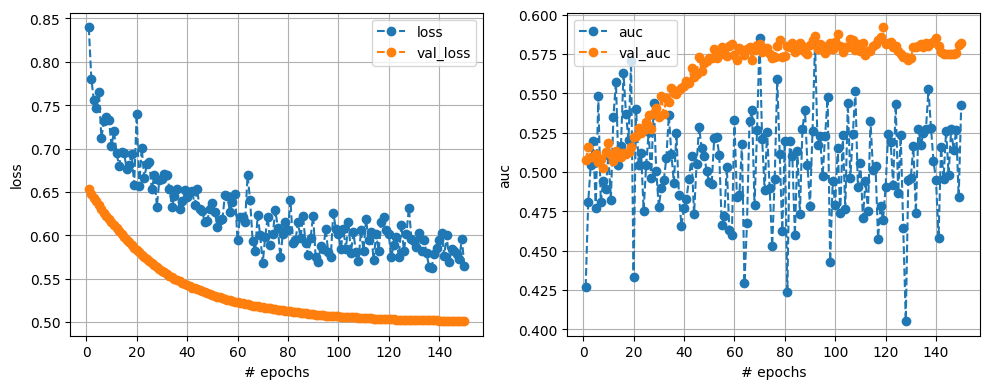

20/20 [==============================] - 4s 166ms/step - loss: 0.5644 - auc: 0.5426 - val_loss: 0.5012 - val_auc: 0.5818


In [38]:
# Extract the best hyperparameters
best_trial = study.best_trial.params

# Base model
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rebuild the model with the best hyperparameters
model = build_model(base_model=base_resnet18, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Callbacks
rn_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn_checkpoint = ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)
rn_plot_callback = PlotLearning()

# Retrain the model
history = model.fit(train_data_augmented,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[rn_callback, rn_checkpoint, rn_plot_callback],
                   )

Max Sensitivity at Specificity >= 0.79: 0.24


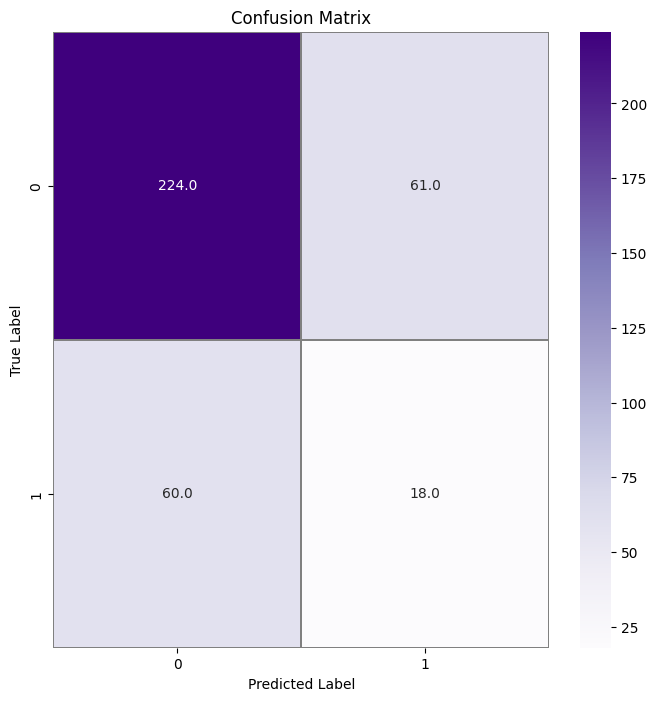

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       285
           1       0.23      0.23      0.23        78

    accuracy                           0.67       363
   macro avg       0.51      0.51      0.51       363
weighted avg       0.67      0.67      0.67       363

                Model Name  Max Sensitivity at Specificity 0.79   AUC  \
0  ResNet18-TL-no-CW-tuned                                 0.24  0.47   

   F1-Score Positive Class  Accuracy  Sensitivity  Specificity   PPV   NPV  \
0                     0.23      0.67         0.23         0.79  0.23  0.79   

    PLR   NLR  
0  1.08  0.98  


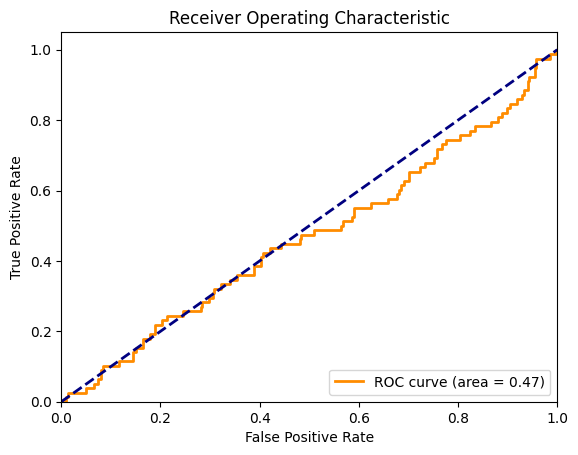

In [39]:
get_model_metrics(test_data=prep_test_data, model=model, model_name='ResNet18-TL-no-CW-tuned')